# Supplementary Project

Names:

 1. Mohammad Amini, SID: 810100294

 2. Farzad Mohammadi, SID: 810100552

## Feature Extraction

Before performing any Machine Learning operation on our given EEG signals, we have to extract some features from these signals. To this purpose, we have used **eeglib** library, which is documented [here](https://eeglib.readthedocs.io/en/latest/), and a research paper by the developer of this library can be found [here](https://www.sciencedirect.com/science/article/pii/S2352711021000753).

This library is capable of extracting features from different facets of EEG signals. These features fall into different categories: Transformations, Frequency domain, Time domain, and Complexity. Most of these features are applied to a single channel. In this project we have used 8 of these features that we thought it would suit our situation. These features are [three hjorth parameters](https://www.sciencedirect.com/science/article/pii/0013469470901434), [DFA](https://www.scopus.com/record/display.uri?eid=2-s2.0-34547856203&origin=inward&txGid=30230674f6f8461317b8db961abb5a21&featureToggles=FEATURE_NEW_DOC_DETAILS_EXPORT:1), [sampEn](https://journals.physiology.org/doi/full/10.1152/ajpheart.2000.278.6.H2039), [LZC](https://ieeexplore.ieee.org/document/4015609/), [PFD](https://ieeexplore.ieee.org/document/465426), and [HFD](https://www.sciencedirect.com/science/article/abs/pii/0167278988900814). Each of these features yield a value for every channel, so for each feature we have a 126-sized vector.

An important note is that this library doesn't segment our EEG signal into time periods; consequently, we have done this part manually. We have segmented EEG signals into 200 ms periods and then extracted above feature vectors for each of these time periods. The resulting dataset dimension is $90 \times 35 \times 1008$, the format of which is **$epochs \times total \space time \space periods \times features$**.

Importing libraries

In [1]:
import numpy as np; np.set_printoptions(suppress=True, precision=3, threshold=6)
import eeglib
from scipy.io import loadmat
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from eeglib.helpers import Helper

Loading dataset

In [ ]:
mat1 = loadmat('S2T2B1.mat')["a"]
mat2= loadmat('S2T2B2.mat')["a"]

In [ ]:
features_list = ["hjorthActivity", "hjorthComplexity", "hjorthMobility", "DFA", "sampEn", "LZC", "PFD", "HFD"]
step = 100
total_steps = 3500/step

if int(total_steps) != total_steps:
    raise Exception("total step must be integer")
total_steps = int(total_steps)

# initializing dataset
dataset = np.zeros((90, total_steps, len(features_list)*126))

# iterating over epochs
for epoch in range(dataset.shape[0]):

    # iterating over time steps (time periods)
    for step_index in range(total_steps):
        if epoch < 45:
            helper = Helper(mat1[epoch, :, step_index*step:(step_index+1)*step])
        else:
            helper = Helper(mat2[epoch-45, :, step_index*step:(step_index+1)*step])
        
        # iterating over features
        for i, feature in enumerate(features_list):
            feat_fun = getattr(helper.eeg, feature)
            feat_vec = feat_fun()
            dataset[epoch, step_index, i*126:(i+1)*126] = feat_vec

y = np.array([0 if i < 45 else 1 for i in range(90)])

## Classification

First of all, we have reduced dimension of feature space from 1008 features to 17 features. Then, we have standardized the scales in the data, and after that we have trained an SVM classifier using data.

In [248]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from random import randint

# initializing
test_acc_vec = []
test_acc_vec_se = []
n = 20

# looping over time periods
for period in range(35):

    # scaling data (preparing it for SVM)
    x = scale(dataset[:, period, :])

    # reducing data dimension
    x_pca = PCA(17).fit_transform(x)
    
    # for every time period we perform random split n times
    tmp_acc_arr = []
    for _ in range(n):
        x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=randint(10, 25))

        clf = SVC(C=100, gamma=0.02)

        clf.fit(x_train, y_train)
        y_pre_test = clf.predict(x_test)
        tmp_acc_arr.append(accuracy_score(y_test, y_pre_test))
    
    test_acc_vec_se.append(np.array(tmp_acc_arr).std()/np.sqrt(n))
    test_acc_vec.append(np.array(tmp_acc_arr).mean())

Plotting results

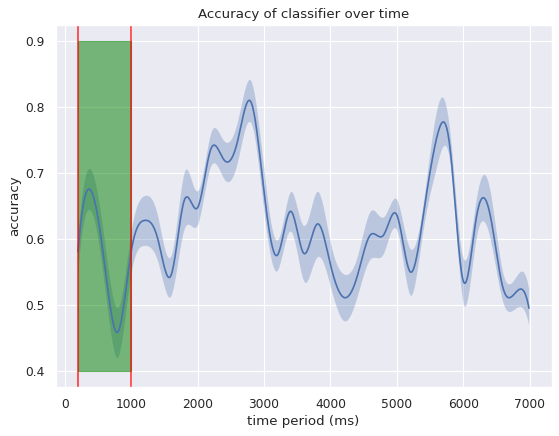

In [249]:
from scipy.interpolate import interp1d

plt.figure(figsize=(8, 6), dpi=80)
time_vec = range(200, 200*36, 200)
time_vec_h = np.arange(200, 200*35, 10)
acc_cube = interp1d(time_vec, test_acc_vec, kind="cubic", fill_value="extrapolate")
acc_cube_se = interp1d(time_vec, test_acc_vec_se, kind="cubic", fill_value="extrapolate")

plt.plot(time_vec_h, acc_cube(time_vec_h))
plt.fill_between(time_vec_h, acc_cube(time_vec_h)-acc_cube_se(time_vec_h), acc_cube(time_vec_h)+acc_cube_se(time_vec_h),
                    alpha=0.3)
plt.axvline(1000, color="red", alpha=0.75)
plt.axvline(200, color="red", alpha=0.75)
plt.fill_between(time_vec_h, 0.4, 0.9, where=time_vec_h<=1000, color="green", alpha=0.5)
plt.xlabel("time period (ms)")
plt.ylabel("accuracy")
plt.title("Accuracy of classifier over time")
plt.show()

As we can see, before 1000 ms accuracy is near random (0.5) and after object is seen by the subject we are getting a peak in accuracy in around 3000 ms, which is what was expected.